In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
import os
import cv2
import time
import glob
import shutil
import random
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
sns.set_style('darkgrid')
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.models import Model, load_model, Sequential
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
print ('modules loaded')

modules loaded


In [14]:
data_dir = '../input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets'

In [17]:
# Split The Data 
# Fseries=>Files=>Filepaths
# Lseries=>Classes=>Lables
def define_paths(data_dir):
    filepaths = []
    labels = []
    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
    return filepaths, labels

def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

def create_df(data_dir):
   
    files, classes = define_paths(data_dir)
    df = define_df(files, classes)
    
    strat=df['labels']
    train_df, dummy_df=train_test_split(df,  train_size=0.8, shuffle=True, random_state=123, stratify=strat)
    
    strat = dummy_df['labels']
    valid_df, test_df=train_test_split(dummy_df,  train_size=0.5, shuffle=True, random_state=123, stratify=strat)
    return train_df, valid_df, test_df

In [18]:
train_df, valid_df, test_df = create_df(data_dir)

In [20]:
# Data Preprocessing
# Data Generator with Data Augmentaion
batch_size = 40
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size
def scalar(img):
    return img
tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
ts_gen = ImageDataGenerator(preprocessing_function= scalar)
train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)
valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)
test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= test_batch_size)

Found 12000 validated image filenames belonging to 3 classes.
Found 1500 validated image filenames belonging to 3 classes.
Found 1500 validated image filenames belonging to 3 classes.


In [21]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model
base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

2022-10-27 19:07:08.052689: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-27 19:07:08.213719: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-27 19:07:08.214505: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-27 19:07:08.215916: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

43950080/43941136 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb3 (Functional)  (None, 1536)              10783535  
_________________________________________________________________
batch_normalization (BatchNo (None, 1536)              6144      
_________________________________________________________________
dense (Dense)                (None, 256)               393472    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 771       
Total params: 11,183,922
Trainable params: 11,093,547
Non-trainable params: 90,375
_________________________________________________________________


In [25]:
batch_size = 100
hist = model.fit(train_gen,
                 steps_per_epoch=train_gen.samples//batch_size,
                 validation_data=valid_gen,
                 validation_steps=valid_gen.samples//batch_size,
                 epochs=10)

2022-10-27 19:12:53.319134: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-10-27 19:13:07.775274: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


120/120 [==============================] - 112s 763ms/step - loss: 5.7940 - accuracy: 0.9252 - val_loss: 4.2624 - val_accuracy: 0.9300
Epoch 2/10
120/120 [==============================] - 80s 666ms/step - loss: 3.1663 - accuracy: 0.9760 - val_loss: 2.4286 - val_accuracy: 0.9917
Epoch 3/10
120/120 [==============================] - 75s 623ms/step - loss: 1.9441 - accuracy: 0.9904 - val_loss: 1.4942 - val_accuracy: 0.9950
Epoch 4/10
120/120 [==============================] - 72s 602ms/step - loss: 1.2504 - accuracy: 0.9881 - val_loss: 0.9620 - val_accuracy: 0.9967
Epoch 5/10
120/120 [==============================] - 71s 590ms/step - loss: 0.8171 - accuracy: 0.9952 - val_loss: 0.6394 - val_accuracy: 0.9983
Epoch 6/10
120/120 [==============================] - 71s 587ms/step - loss: 0.5565 - accuracy: 0.9940 - val_loss: 0.4327 - val_accuracy: 0.9983
Epoch 7/10
120/120 [==============================] - 70s 581ms/step - loss: 0.3917 - accuracy: 0.9946 - val_loss: 0.3033 - val_accuracy: 0.

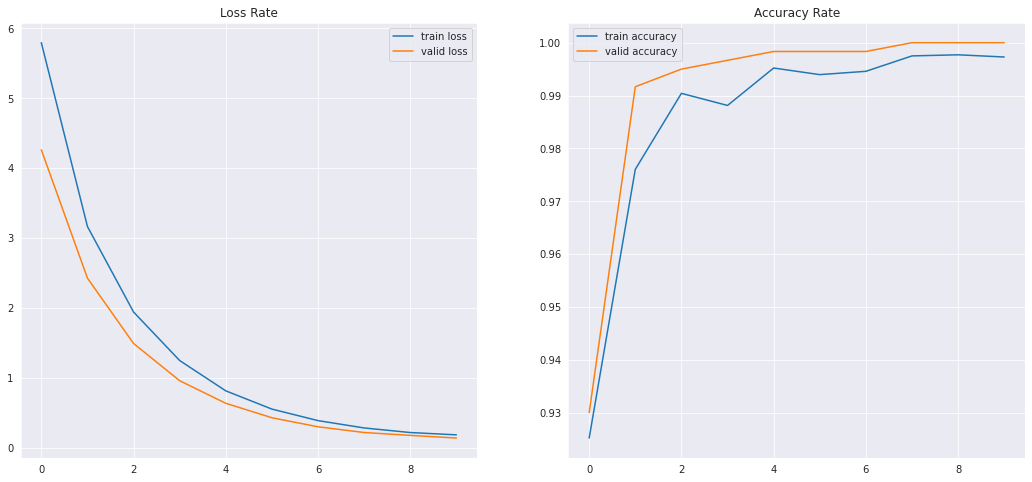

In [26]:
# Accuracy and Loss
plt.figure(figsize=(18, 8))

plt.subplot(1, 2, 1)
plt.plot(hist.history['loss'],label='train loss')
plt.plot(hist.history['val_loss'],label='valid loss')
plt.title('Loss Rate')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hist.history['accuracy'],label='train accuracy')
plt.plot(hist.history['val_accuracy'],label='valid accuracy')
plt.title('Accuracy Rate')
plt.legend()

plt.show()

In [28]:
# Model Evaluation
train_score = model.evaluate(train_gen)
valid_score = model.evaluate(valid_gen)
test_score = model.evaluate(test_gen)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

20/20 [==============================] - 23s 1s/step - loss: 0.1434 - accuracy: 1.0000
Train Loss:  0.14325132966041565
Train Accuracy:  0.999833345413208
--------------------
Validation Loss:  0.1438867747783661
Validation Accuracy:  1.0
--------------------
Test Loss:  0.14337512850761414
Test Accuracy:  1.0


In [29]:
# Prediction
batch_size = 100
target_names = ['adenocarcinoma', 'benign', 'squamous cell carcinoma']
Y_pred = model.predict_generator(test_gen)
y_pred = np.argmax(Y_pred, axis=1)
print(y_pred)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


[0 1 1 ... 2 1 0]


In [31]:
# Confusion Matrix
cm = confusion_matrix(test_gen.classes, y_pred)

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap = plt.cm.Blues):
  plt.figure(figsize=(10, 10))
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print('Normalized Confusion Matrix')
  else:
    print('Confusion Matrix, Without Normalization')
  
  print(cm)

  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center', color = 'white' if cm[i, j] > thresh else 'black')

  plt.tight_layout()
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label')

Confusion Matrix, Without Normalization
[[500   0   0]
 [  0 500   0]
 [  0   0 500]]


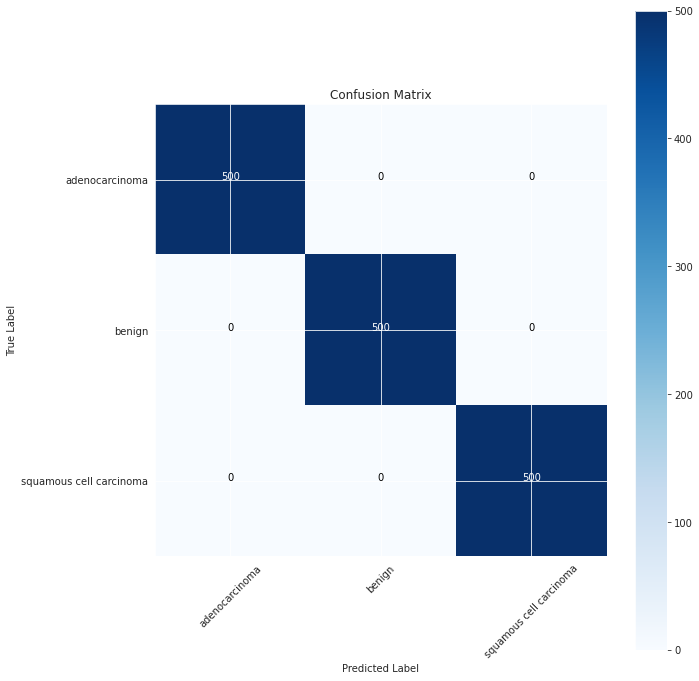

In [32]:
plot_confusion_matrix(cm=cm, classes=target_names, title = 'Confusion Matrix')

In [35]:
# Classification Report
from sklearn.metrics import classification_report
print(classification_report(test_gen.classes, y_pred, target_names=target_names))

                         precision    recall  f1-score   support

         adenocarcinoma       1.00      1.00      1.00       500
                 benign       1.00      1.00      1.00       500
squamous cell carcinoma       1.00      1.00      1.00       500

               accuracy                           1.00      1500
              macro avg       1.00      1.00      1.00      1500
           weighted avg       1.00      1.00      1.00      1500



In [36]:
#Save the model
model.save('Efficientb3-Lung Cancer.h5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
